In [5]:
# Gerekli kütüphaneler
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer  # Eksik olan import eklendi
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


In [7]:
# Eğitim ve test verilerini yükleyelim
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# Test verisindeki 'id' sütununu saklayalım
test_ids = test_data['id'].copy()

# 'id' ve 'Potential' sütunlarını kaldıralım
train_data = train_data.drop(['id', 'Potential'], axis=1)
test_data = test_data.drop(['id', 'Potential'], axis=1)

# 'value_increased' sütununu 1 ve 0 olarak dönüştürelim
train_data['value_increased'] = train_data['value_increased'].astype(int)

# 'Caps / Goals' sütununu işleyelim
def process_caps_goals(value):
    if pd.isnull(value):
        return 0
    caps_goals = str(value).split('/')
    if len(caps_goals) >= 1:
        caps = caps_goals[0].strip()
        try:
            caps = int(caps)
            if caps > 0:
                return 1
            else:
                return 0
        except:
            return 0
    else:
        return 0

train_data['National_Team'] = train_data['Caps / Goals'].apply(process_caps_goals)
test_data['National_Team'] = test_data['Caps / Goals'].apply(process_caps_goals)

# 'Caps / Goals' sütununu kaldıralım
train_data = train_data.drop('Caps / Goals', axis=1)
test_data = test_data.drop('Caps / Goals', axis=1)

# 'Foot' sütununu dönüştürelim
foot_mapping = {'Right': 0, 'Left': 1}
train_data['Foot'] = train_data['Foot'].map(foot_mapping)
test_data['Foot'] = test_data['Foot'].map(foot_mapping)

train_data['Foot'] = train_data['Foot'].fillna(0)
test_data['Foot'] = test_data['Foot'].fillna(0)

# 'Height' ve 'Weight' sütunlarını işleyelim
train_data['Height'] = train_data['Height'].str.replace('CM', '').astype(float)
test_data['Height'] = test_data['Height'].str.replace('CM', '').astype(float)

train_data['Weight'] = train_data['Weight'].str.replace('KG', '').astype(float)
test_data['Weight'] = test_data['Weight'].str.replace('KG', '').astype(float)

# Kaleci özelliklerini düzenleyelim
train_data['Is_Goalkeeper'] = train_data['Positions'].apply(lambda x: 1 if 'GK' in str(x) else 0)
test_data['Is_Goalkeeper'] = test_data['Positions'].apply(lambda x: 1 if 'GK' in str(x) else 0)

gk_attributes = ['Aerial Reach', 'Command of Area', 'Communication', 'Eccentricity',
                 'Handling', 'Kicking', 'One on Ones', 'Punching (Tendency)',
                 'Reflexes', 'Rushing Out (Tendency)', 'Throwing']

for col in gk_attributes:
    train_data.loc[train_data['Is_Goalkeeper'] == 0, col] = 0
    test_data.loc[test_data['Is_Goalkeeper'] == 0, col] = 0

# 'Positions' sütununu işleyelim
positions_train = train_data['Positions'].str.strip().str.split(' ')
positions_test = test_data['Positions'].str.strip().str.split(' ')

positions = pd.concat([positions_train, positions_test], ignore_index=True)
all_positions = set([pos for sublist in positions.dropna() for pos in sublist])

def encode_positions(df, positions_list):
    for pos in positions_list:
        df['Position_' + pos] = df['Positions'].apply(lambda x: 1 if pos in str(x).split(' ') else 0)
    return df

train_data = encode_positions(train_data, all_positions)
test_data = encode_positions(test_data, all_positions)

train_data = train_data.drop('Positions', axis=1)
test_data = test_data.drop('Positions', axis=1)

# Eksik değerleri dolduralım
numeric_cols = train_data.select_dtypes(include=[np.number]).columns.tolist()
if 'value_increased' in numeric_cols:
    numeric_cols.remove('value_increased')

imputer_num = SimpleImputer(strategy='mean')
train_data[numeric_cols] = imputer_num.fit_transform(train_data[numeric_cols])
test_data[numeric_cols] = imputer_num.transform(test_data[numeric_cols])

# Kategorik sütunları kontrol edelim
categorical_cols = train_data.select_dtypes(include=['object']).columns.tolist()
if categorical_cols:
    imputer_cat = SimpleImputer(strategy='most_frequent')
    train_data[categorical_cols] = imputer_cat.fit_transform(train_data[categorical_cols])
    test_data[categorical_cols] = imputer_cat.transform(test_data[categorical_cols])

# Hedef değişken ve özellikleri ayıralım
X = train_data.drop('value_increased', axis=1)
y = train_data['value_increased']


In [9]:
train_data.head()

,value_increased,Ability,Foot,Height,Weight,Aerial Reach,Command of Area,Communication,Eccentricity,First Touch,...,Position_MR,Position_DC,Position_MC,Position_WBL,Position_AMR,Position_ML,Position_GK,Position_DR,Position_DM,Position_DL
0,0,46.0,0.0,178.0,72.0,0.0,0.0,0.0,0.0,55.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,48.0,0.0,185.0,82.0,55.0,60.0,70.0,65.0,45.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0,58.0,1.0,185.0,80.0,0.0,0.0,0.0,0.0,55.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1,38.0,0.0,185.0,74.0,0.0,0.0,0.0,0.0,35.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,47.0,0.0,193.0,73.0,35.0,40.0,35.0,25.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [11]:
# Korelasyon matrisi
corr_matrix = X.corr().abs()

# Üst üçgen matrisi alalım
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Yüksek korelasyonlu özellikleri belirleyelim (0.9'dan büyük)
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

# Yüksek korelasyonlu özellikleri kaldıralım
X = X.drop(columns=to_drop)
test_data = test_data.drop(columns=to_drop)


In [13]:
# SMOTE uygulayalım
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)


In [15]:
# Verileri eğitim ve doğrulama setlerine ayıralım
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)


In [17]:
# XGBoost modelini tanımlayalım
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Hyperparametre gridini tanımlayalım
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1],
    'gamma': [0, 0.1],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [1, 10]
}

# StratifiedKFold ile çapraz doğrulama yapalım
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Grid Search
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='f1', cv=kfold, n_jobs=-1, verbose=1)
grid_result = grid_search.fit(X_train, y_train)

# En iyi sonuçları gösterelim
print(f"En iyi F1 Skoru: {grid_result.best_score_:.4f} elde edildi, parametreler: {grid_result.best_params_}")


Fitting 5 folds for each of 384 candidates, totalling 1920 fits


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [09:36:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [09:36:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [09:36:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [09:36:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

En iyi F1 Skoru: 0.9188 elde edildi, parametreler: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'reg_alpha': 0.1, 'reg_lambda': 1, 'subsample': 0.8}


In [19]:
# En iyi parametrelerle modelimizi oluşturalım
best_params = grid_result.best_params_
best_model = XGBClassifier(**best_params, use_label_encoder=False, eval_metric='logloss')

# Modeli eğitelim
best_model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0.1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [21]:
# Doğrulama seti üzerinde tahmin yapalım
y_val_pred = best_model.predict(X_val)
y_val_pred_probs = best_model.predict_proba(X_val)[:, 1]

# Sınıflandırma raporu
print("Doğrulama seti sınıflandırma raporu:")
print(classification_report(y_val, y_val_pred))

# F1 Skoru
f1 = f1_score(y_val, y_val_pred)
print(f"F1 Skoru: {f1:.4f}")

# ROC AUC Skoru
auc_score = roc_auc_score(y_val, y_val_pred_probs)
print(f"ROC AUC Skoru: {auc_score:.4f}")


Doğrulama seti sınıflandırma raporu:
              precision    recall  f1-score   support

           0       0.91      0.92      0.92        79
           1       0.92      0.91      0.92        79

    accuracy                           0.92       158
   macro avg       0.92      0.92      0.92       158
weighted avg       0.92      0.92      0.92       158

F1 Skoru: 0.9172
ROC AUC Skoru: 0.9797


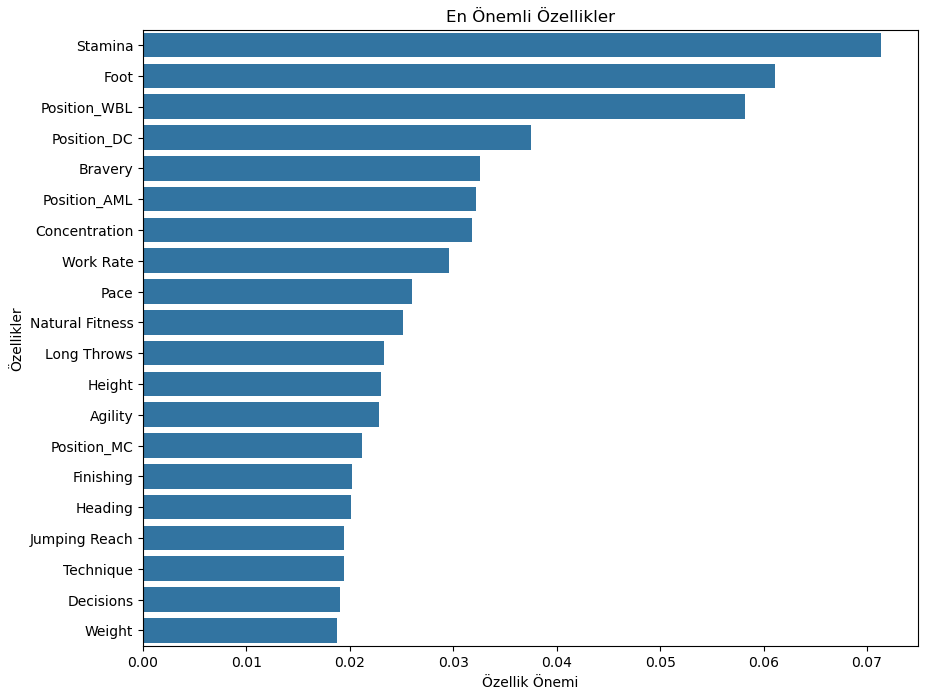

In [23]:
# Özellik önemlerini görselleştirelim
import seaborn as sns

feature_importances = pd.Series(best_model.feature_importances_, index=X_train.columns)
feature_importances = feature_importances.sort_values(ascending=False)[:20]  # İlk 20 özelliği alalım

plt.figure(figsize=(10, 8))
sns.barplot(x=feature_importances.values, y=feature_importances.index)
plt.title('En Önemli Özellikler')
plt.xlabel('Özellik Önemi')
plt.ylabel('Özellikler')
plt.show()


In [25]:
# Test verisi üzerinde tahmin yapalım
y_test_pred = best_model.predict(test_data)


In [ ]:
# Tahminleri True ve False olarak dönüştürelim
y_test_pred_bool = y_test_pred.astype(bool)

# Sonuçları hazırlayalım
submission = pd.DataFrame({
    'id': test_ids,
    'value_increased': y_test_pred_bool
})

# CSV dosyasına kaydedelim
submission.to_csv('sample_submission1.csv', index=False)
print("Tahminler sample_submission.csv dosyasına kaydedildi.")
